### Abstract
This notebook presents a comprehensive data analysis and predictive modeling approach aimed at understanding the factors influencing primary energy consumption per capita (kWh/person). The analysis begins with data preprocessing, including handling missing values, type conversion, feature selection, outlier handling, and normalization to prepare the dataset for further analysis. A significant part of the analysis involves feature selection using Random Forest Regressor and correlation analysis to identify the key variables that impact energy consumption. The selected features include GDP per capita, access to clean fuels for cooking, energy intensity level of primary energy, access to electricity, and various sources of electricity production. The notebook proceeds to model training and evaluation, where a Random Forest Regressor is employed to predict energy consumption per capita. Model performance is assessed using metrics such as RMSE, MAE, R-squared, and Explained Variance to ensure reliability and accuracy in predictions.

### Objective
The primary objective of this notebook is to analyze and model the determinants of primary energy consumption per capita using a dataset that encompasses various economic, social, and technological factors. By employing machine learning techniques, specifically a Random Forest Regressor, the study aims to identify and quantify the impact of selected features on energy consumption. This understanding is critical for policymakers, researchers, and stakeholders in the energy sector to make informed decisions regarding energy planning, efficiency improvements, and sustainable development strategies. The notebook emphasizes the importance of accurate feature selection and the effectiveness of Random Forest in handling such predictive tasks, offering insights into the complex dynamics of energy consumption patterns across different regions.


## Data Preprocessing
In this step, we perform initial data preprocessing tasks such as handling missing values, type conversion, and feature selection, Outlier Handling and Normalization to prepare the data for analysis and modeling.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import Ridge
!pip install opendatasets
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/anshtanwar/global-data-on-sustainable-energy') # insert ypu kaggle  username and key
data = pd.read_csv('/content/global-data-on-sustainable-energy/global-data-on-sustainable-energy (1).csv')



#file_path = '/content/drive/MyDrive/ds/dataset.gsheet'
#data = pd.read_csv(file_path)
#print(data.dtypes)
data.info()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ramcuts
Your Kaggle Key: ··········


100%|██████████| 174k/174k [00:00<00:00, 33.4MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (T

In [ ]:
data.rename(columns={'Density\\n(P/Km2)': 'Density'}, inplace=True)
data['Density'] = pd.to_numeric(data['Density'], errors='coerce')
data = data.drop("Electricity from nuclear (TWh)", axis=1)
data.reset_index(drop=True, inplace=True)
label_encoder = LabelEncoder()
data['Entity'] = label_encoder.fit_transform(data['Entity'])


# Mean Imputation
numeric_columns = data.select_dtypes(include=['float64', 'int64', 'int32']).columns
data_numeric = data[numeric_columns]
mean_imputer = SimpleImputer(strategy='mean')
X_mean_imputed = mean_imputer.fit_transform(data_numeric)
df_mean_imputed = pd.DataFrame(X_mean_imputed, columns=numeric_columns)

#IQR
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return df

data_capped_label = df_mean_imputed.copy()

numerical_columns = df_mean_imputed.select_dtypes(include='number').columns
for column in numerical_columns:
    data_capped_label = cap_outliers_iqr(data_capped_label, column)

from sklearn.preprocessing import StandardScaler

columns_to_normalize = [
    'Access to electricity (% of population)',
    'Access to clean fuels for cooking',
    'Renewable-electricity-generating-capacity-per-capita',
    'Financial flows to developing countries (US $)',
    'Renewable energy share in the total final energy consumption (%)',
    'Electricity from fossil fuels (TWh)',
    'Electricity from renewables (TWh)',
    'Low-carbon electricity (% electricity)',
    'Primary energy consumption per capita (kWh/person)',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'Value_co2_emissions_kt_by_country',
    'Renewables (% equivalent primary energy)',
    'gdp_growth',
    'gdp_per_capita',
    'Land Area(Km2)'
]

# Create the StandardScaler object
scaler = StandardScaler()
data_capped_label[columns_to_normalize] = scaler.fit_transform(data_capped_label[columns_to_normalize])


data_capped_label.isna().sum()

Entity                                                              0
Year                                                                0
Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Renewable-electricity-generating-capacity-per-capita                0
Financial flows to developing countries (US $)                      0
Renewable energy share in the total final energy consumption (%)    0
Electricity from fossil fuels (TWh)                                 0
Electricity from renewables (TWh)                                   0
Low-carbon electricity (% electricity)                              0
Primary energy consumption per capita (kWh/person)                  0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0
Value_co2_emissions_kt_by_country                                   0
Renewables (% equivalent primary energy)                            0
gdp_growth          

### Feature Selection using Random Forest Regressor
In this step, we perform feature selection to prepare the data for analysis and modeling.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = data_capped_label.drop('Primary energy consumption per capita (kWh/person)', axis=1)
y = data_capped_label['Primary energy consumption per capita (kWh/person)']


rf_model = RandomForestRegressor()
rf_model.fit(X, y)


feature_importances = rf_model.feature_importances_
selected_features_rf = X.columns[feature_importances.argsort()[::-1]][:5]  # Replace 5 with the number of features you want

print("Selected Features:", selected_features_rf)

Selected Features: Index(['gdp_per_capita', 'Access to clean fuels for cooking',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Entity',
       'Land Area(Km2)'],
      dtype='object')


### Correlation Analysis
This section is dedicated to analyzing the correlations between different features in the dataset. A heatmap is used to visualize the strength and direction of relationships between variables, aiding in feature selection for modeling.

<Axes: >

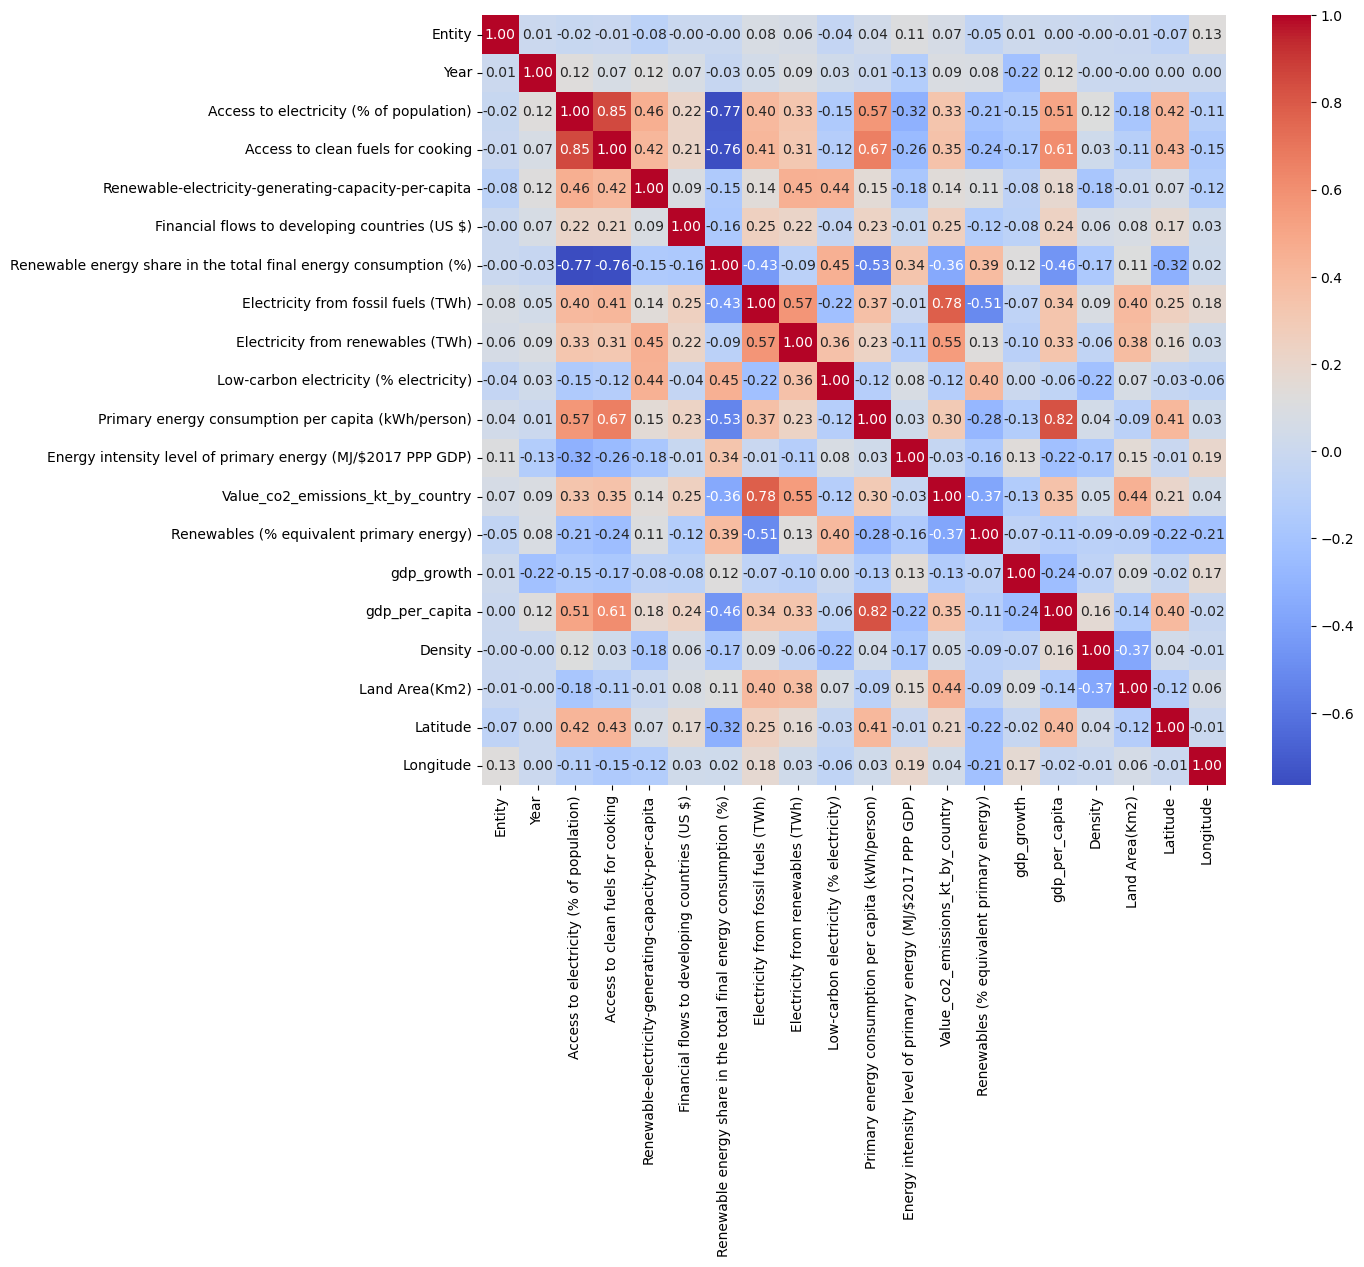

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = data_capped_label.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

We have conducted a comprehensive data analysis to understand the factors influencing 'Primary energy consumption per capita (kWh/person)'. Our analysis includes a correlation matrix visualization and feature selection using a Random Forest Regressor.

### Correlation Matrix Insights:

The heatmap provides a visual representation of the correlations between variables. Key observations include:

- **Strong Positive Correlations:**
  - `gdp_per_capita` shows a strong positive correlation with our target variable, indicating that as GDP per capita increases, so does energy consumption per capita.
  - `Access to electricity (% of population)` is positively correlated, suggesting that higher access to electricity is associated with increased energy consumption.

- **Strong Negative Correlations:**
  - `Renewable-electricity-generating-capacity-per-capita` and `Renewables (% equivalent primary energy)` have negative correlations, hinting that higher renewable capacity might be associated with lower primary energy consumption per capita, possibly due to efficiency and sustainability factors.

- **Moderate Correlations:**
  - Variables such as `Energy intensity level of primary energy (MJ/$2017 PPP GDP)` and `Access to clean fuels for cooking` exhibit moderate positive correlations with the target variable.

### Random Forest Regressor Feature Selection:

The Random Forest model has identified the following features as significant in predicting our target variable:

- `gdp_per_capita`
- `Access to clean fuels for cooking`
- `Energy intensity level of primary energy (MJ/$2017 PPP GDP)`
- `Entity`
- `Land Area(Km2)`

These features were selected based on their importance scores, which measure their contribution to the model's predictive power.

### Combined Analysis:

Considering both the correlation matrix and the feature selection output, `gdp_per_capita` and `Energy intensity level of primary energy (MJ/$2017 PPP GDP)` stand out as significant predictors. So the final predictors from both analysis would be as following

- `gdp_per_capita`
- `Access to clean fuels for cooking`
- `Energy intensity level of primary energy (MJ/$2017 PPP GDP)`
- `Access to electricity (% of population)`
- `Electricity from fossil fuels (TWh)`
- `Electricity from renewables (TWh)`
- `Value_co2_emissions_kt_by_country`
- `Financial flows to developing countries (US $)`
- `Renewable energy share in the total final energy consumption (%)`
- `Renewables (% equivalent primary energy)`

### Model Training and Evaluation
Here, we split the data into training and testing sets, train a Random Forest Regressor model on the training set, and evaluate its performance on the test set using metrics such as RMSE, MAE, R-squared, and Explained Variance.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Splitting data into Training 70%, Test set 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Random Forest regression
random_forest = RandomForestRegressor(n_estimators=100, random_state=1)
random_forest.fit(X_train, y_train)

# Predictions
y_pred = random_forest.predict(X_test)

# Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf = mean_absolute_error(y_test, y_pred)
r_squared_rf = r2_score(y_test, y_pred)
explained_var_rf = explained_variance_score(y_test, y_pred)

# Display the metrics
print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")
print(f"R-squared: {r_squared_rf}")
print(f"Explained Variance: {explained_var_rf}")


RMSE: 0.14834873885108124
MAE: 0.060508555662879104
R-squared: 0.9775710771915279
Explained Variance: 0.9775710913902748


### Linear Regression with OLS (Ordinary Least Squares):

Performing linear regression using OLS. This can help answer questions about the significance of relationships, model assumptions, and which independent variables are significant.

In [ ]:
import statsmodels.api as sm

Z = data_capped_label.drop('Primary energy consumption per capita (kWh/person)', axis=1)  # Features
target_variable = data_capped_label['Primary energy consumption per capita (kWh/person)']  # Your preferred target variable name

Z = sm.add_constant(X)
model = sm.OLS(target_variable, Z).fit()
print(model.summary())

                                            OLS Regression Results                                            
Dep. Variable:     Primary energy consumption per capita (kWh/person)   R-squared:                       0.824
Model:                                                            OLS   Adj. R-squared:                  0.823
Method:                                                 Least Squares   F-statistic:                     892.3
Date:                                                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                                                        18:36:11   Log-Likelihood:                -2011.3
No. Observations:                                                3649   AIC:                             4063.
Df Residuals:                                                    3629   BIC:                             4187.
Df Model:                                                          19                                         
C

### Variance Inflation Factor (VIF) Calculation:

We now calculate the VIF for each feature, addressing questions about multicollinearity and the independence of predictor variables.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

selected_predictors = ['gdp_per_capita', 'Access to clean fuels for cooking',
                       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                       'Access to electricity (% of population)', 'Electricity from fossil fuels (TWh)',
                       'Electricity from renewables (TWh)', 'Value_co2_emissions_kt_by_country',
                       'Financial flows to developing countries (US $)',
                       'Renewable energy share in the total final energy consumption (%)',
                       'Renewables (% equivalent primary energy)']

X_selected = X[selected_predictors]

vif_data = pd.DataFrame()
vif_data["Variable"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
print(vif_data)

                                            Variable       VIF
0                                     gdp_per_capita  1.727024
1                  Access to clean fuels for cooking  4.860102
2  Energy intensity level of primary energy (MJ/$...  1.297835
3            Access to electricity (% of population)  4.649362
4                Electricity from fossil fuels (TWh)  4.394802
5                  Electricity from renewables (TWh)  2.944577
6                  Value_co2_emissions_kt_by_country  2.810134
7     Financial flows to developing countries (US $)  1.119069
8  Renewable energy share in the total final ener...  3.917419
9           Renewables (% equivalent primary energy)  2.216217


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
selected_predictors = ['gdp_per_capita', 'Access to clean fuels for cooking',
                       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                       'Access to electricity (% of population)', 'Electricity from fossil fuels (TWh)',
                       'Electricity from renewables (TWh)', 'Value_co2_emissions_kt_by_country',
                       'Financial flows to developing countries (US $)',
                       'Renewable energy share in the total final energy consumption (%)',
                       'Renewables (% equivalent primary energy)']
X_selected = X[selected_predictors]


X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Ridge Regression RMSE: {rmse}')


Ridge Regression RMSE: 0.4632316718848044


### P-Value Calculation

Using the t-statistic, you calculate the p-value, which indicates the probability of observing the given data (or more extreme) under the null hypothesis. The p-value is derived from the t-distribution, considering the degrees of freedom determined by sample size and the number of predictors in the model.

- **Low p-value (≤ 0.05):** Strong evidence against the null hypothesis, suggesting a significant relationship between the predictor and the outcome.
- **High p-value (> 0.05):** Weak evidence against the null hypothesis, indicating that the coefficient might not be significantly different from 0.

This approach helps in determining the statistical significance of each coefficient in a regression model, guiding decisions on the relevance of predictor variables.


In [ ]:
import statsmodels.api as sm

X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

                                            OLS Regression Results                                            
Dep. Variable:     Primary energy consumption per capita (kWh/person)   R-squared:                       0.824
Model:                                                            OLS   Adj. R-squared:                  0.823
Method:                                                 Least Squares   F-statistic:                     892.3
Date:                                                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                                                        18:36:48   Log-Likelihood:                -2011.3
No. Observations:                                                3649   AIC:                             4063.
Df Residuals:                                                    3629   BIC:                             4187.
Df Model:                                                          19                                         
C

### **P Values of all numerical columns in th dataset:**

- `Entity`: **0.034**
- `Year`: 0.000
- `Access to electricity (% of population)`: 0.000
- `Access to clean fuels for cooking`: 0.000
- `Renewable-electricity-generating-capacity-per-capita`: 0.000
- **`Financial flows to developing countries (US $)`: **0.263****
- `Renewable energy share in the total final energy consumption (%)`: 0.000
- `Electricity from fossil fuels (TWh)`: 0.000
- `Electricity from renewables (TWh)`: 0.000
- `Low-carbon electricity (% electricity)`: 0.000
- `Energy intensity level of primary energy (MJ/$2017 PPP GDP)`: 0.000
- `Value_co2_emissions_kt_by_country`: 0.000
- `Renewables (% equivalent primary energy)`: 0.000
- `gdp_growth`: 0.001
- `gdp_per_capita`: 0.000
- `Density`: 0.000
- `Land Area(Km2)`: 0.000
- `Latitude`: 0.000
- `Longitude`: **0.237**

#### Key Findings:
- **Statistically Significant Predictors:**
  - **Access to electricity (% of population):** Coefficient of 0.2056, p < 0.001, suggesting a strong positive relationship.
  - **Year:** Coefficient of -0.0089, p < 0.001, indicating a slight negative trend over time.
  - **Energy intensity level of primary energy (MJ/$2017 PPP GDP):** Coefficient of 0.2509, p < 0.001, showing a significant positive impact.
  - **GDP per capita:** Coefficient of 0.7591, p < 0.001, one of the most significant positive predictors.

- **Insignificant Predictors:**
  - **Financial flows to developing countries (US $):** Coefficient of 0.0083 with p = 0.263, not statistically significant.
  - **Longitude:** Coefficient of 0.0002 with p = 0.237, indicating no significant effect.

#### Model Diagnostics:
- The **F-statistic** of 892.3 with a p-value < 0.001 strongly rejects the null hypothesis that none of the predictors are useful in explaining the variability in the dependent variable.
- **Durbin-Watson** statistic of 0.219 suggests potential autocorrelation in the residuals, which may need further investigation.
- The **Condition Number** of 7.08e+05 indicates possible issues with multicollinearity, which could affect the reliability of the coefficient estimates.

#### Interpretation:
The model highlights several key drivers behind 'Primary energy consumption per capita,' including access to electricity, energy intensity, and GDP per capita, among others. The presence of statistically insignificant predictors and potential multicollinearity suggests a need for further model refinement, possibly including dimensionality reduction or regularization techniques.

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [ ]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Corretto-17.0.8.8.1 (build 17.0.8.1+8-LTS, mixed mode, sharing)
  Starting server from C:\Users\himav\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\himav\AppData\Local\Temp\tmp24kkztqy
  JVM stdout: C:\Users\himav\AppData\Local\Temp\tmp24kkztqy\h2o_himav_started_from_python.out
  JVM stderr: C:\Users\himav\AppData\Local\Temp\tmp24kkztqy\h2o_himav_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_himav_im7mkn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.949 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
columns_imp = ['gdp_per_capita', 'Access to clean fuels for cooking',
                   'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                   'Access to electricity (% of population)', 'Electricity from fossil fuels (TWh)',
                   'Electricity from renewables (TWh)', 'Value_co2_emissions_kt_by_country',
                   'Financial flows to developing countries (US $)',
                   'Renewable energy share in the total final energy consumption (%)',
                   'Renewables (% equivalent primary energy)',
                   'Primary energy consumption per capita (kWh/person)']

# Keep only the specified columns
filtered_df = data_capped_label[columns_imp]

In [ ]:
data = h2o.H2OFrame(filtered_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])
train["is_train"] = 1
test["is_train"] = 0
drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()
drift_data["is_train"].table()

is_train,Count
0,903
1,2746


In [ ]:
x = list(set(train.col_names) - set(["Primary energy consumption per capita (kWh/person)"]))
from h2o.automl import H2OAutoML
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="Primary energy consumption per capita (kWh/person)", training_frame=train)

AutoML progress: |
18:42:04.313: AutoML: XGBoost is not available; skipping it.
18:42:04.352: _train param, Dropping bad and constant columns: [is_train]
18:42:05.186: _train param, Dropping bad and constant columns: [is_train]
18:42:10.367: _train param, Dropping bad and constant columns: [is_train]
18:42:13.355: _train param, Dropping bad and constant columns: [is_train]
18:42:14.978: _train param, Dropping bad and constant columns: [is_train]
18:42:16.221: _train param, Dropping bad and constant columns: [is_train]
18:42:17.617: _train param, Dropping bad and constant columns: [is_train]
18:42:20.648: _train param, Dropping bad and constant columns: [is_train]
18:42:21.982: _train param, Dropping bad and constant columns: [is_train]
18:42:25.28: _train param, Dropping unused columns: [is_train]
18:42:25.713: _train param, Dropping unused columns: [is_train]
19:00:17.693: New models will be added to existing leaderboard random_split@@Primary_energy_consumption_per_capita__kWh_person_

key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/5
# GBM base models (used / total),1/1
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_2_AutoML_2_20240219_190017,0.0474788,0.0947789,0.00898305,0.121969,0.00898305
GBM_grid_2_AutoML_2_20240219_190017_model_1,0.0490618,0.0990632,0.00981351,0.116835,0.00981351
DRF_2_AutoML_2_20240219_190017,0.0495709,0.0997146,0.00994299,0.132128,0.00994299
XRT_2_AutoML_2_20240219_190017,0.049573,0.100797,0.01016,0.12801,0.01016
GBM_9_AutoML_2_20240219_190017,0.0498754,0.0972091,0.0094496,0.124145,0.0094496
GBM_10_AutoML_2_20240219_190017,0.0518926,0.103232,0.0106569,0.164066,0.0106569
GBM_7_AutoML_2_20240219_190017,0.053397,0.105441,0.0111177,nan,0.0111177
GBM_8_AutoML_2_20240219_190017,0.0543381,0.105399,0.0111089,0.131054,0.0111089
StackedEnsemble_AllModels_1_AutoML_1_20240219_184204,0.069086,0.139481,0.0194551,0.15521,0.0194551
StackedEnsemble_BestOfFamily_1_AutoML_1_20240219_184204,0.0700533,0.141298,0.0199651,0.161088,0.0199651


In [ ]:
best_model = aml.leader
best_model.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.020970401396816395
RMSE: 0.14481160656803857
MAE: 0.05489641205870406
RMSLE: 0.18372306280952258
Mean Residual Deviance: 0.020970401396816395
R^2: 0.9788377659718699
Null degrees of freedom: 902
Residual degrees of freedom: 899
Null deviance: 895.1546662191137
Residual deviance: 18.936272461325206
AIC: -917.1699024058565

Variable importance for GBM_grid_2_AutoML_2_20240219_190017_model_1:


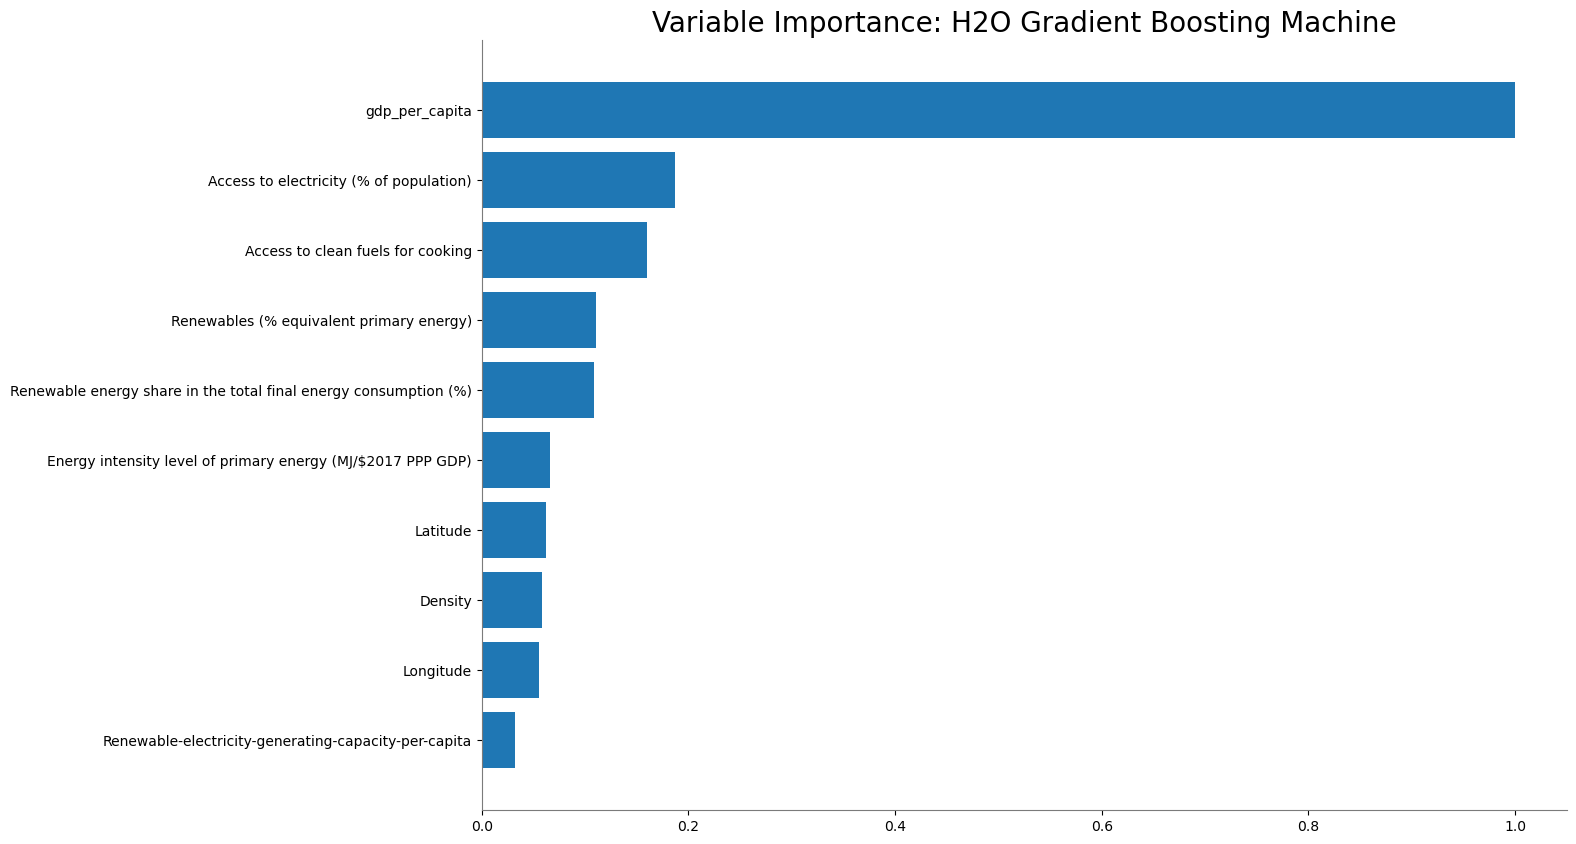

Variable importance for DRF_2_AutoML_2_20240219_190017:


<Figure size 640x480 with 0 Axes>

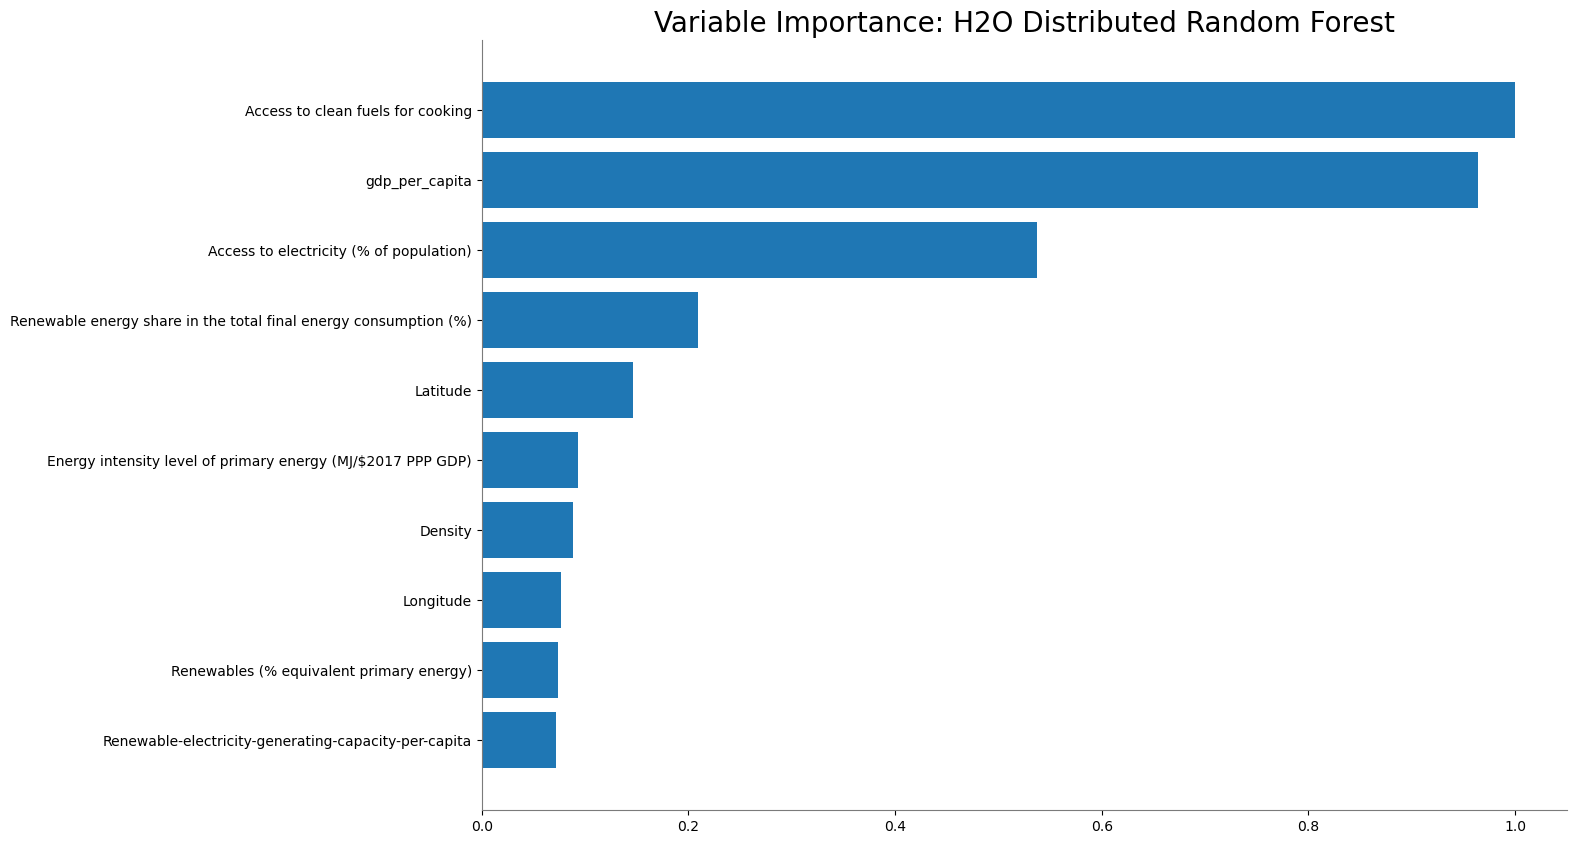

Variable importance for XRT_2_AutoML_2_20240219_190017:


<Figure size 640x480 with 0 Axes>

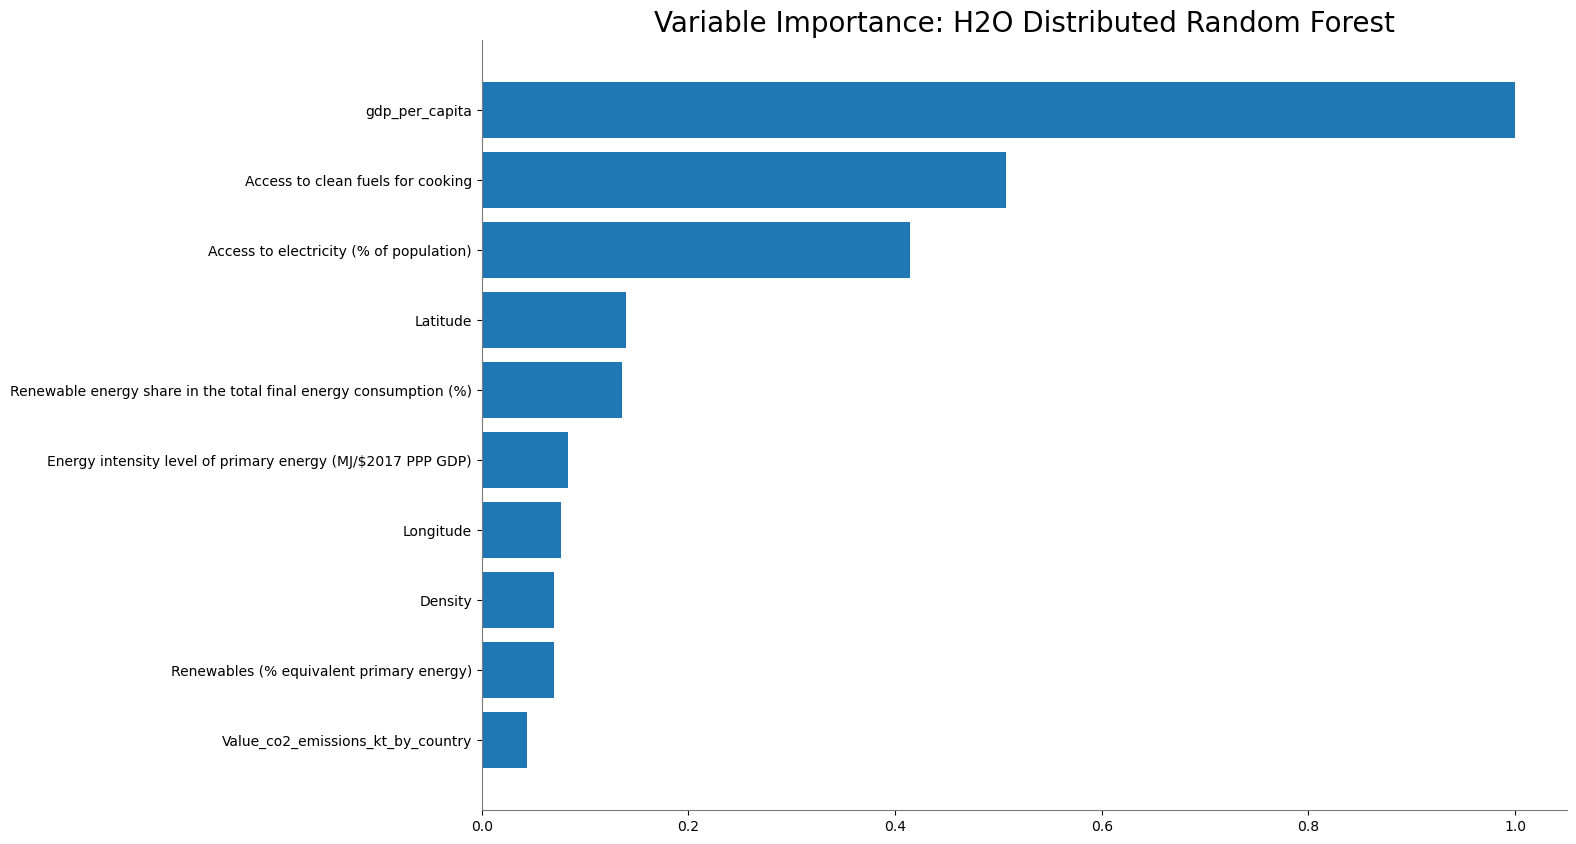

Variable importance for DeepLearning_2_AutoML_2_20240219_190017:


<Figure size 640x480 with 0 Axes>

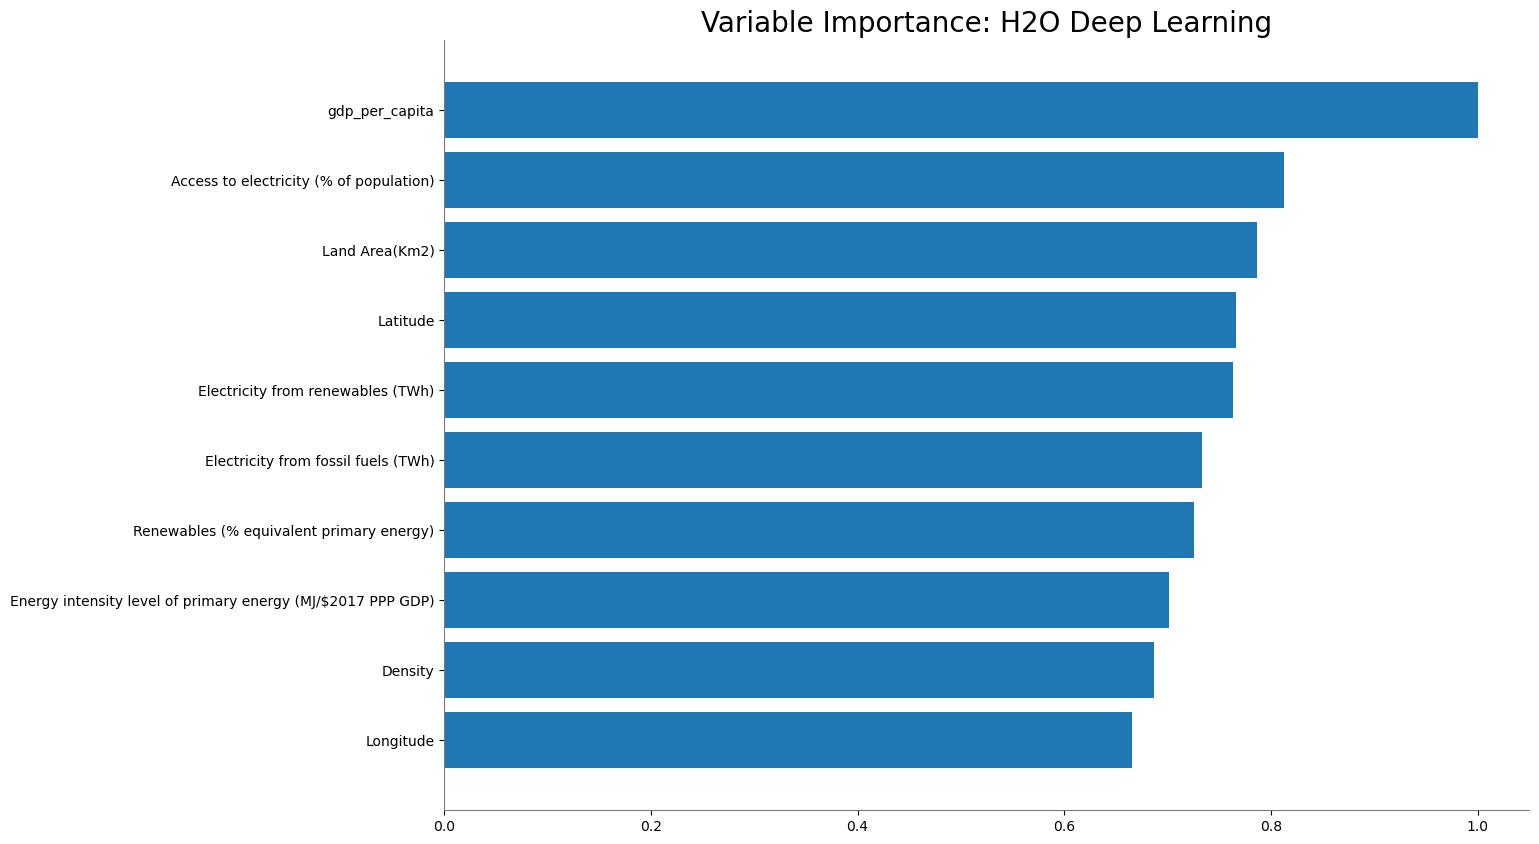

Variable importance for GLM_2_AutoML_2_20240219_190017:


<Figure size 640x480 with 0 Axes>

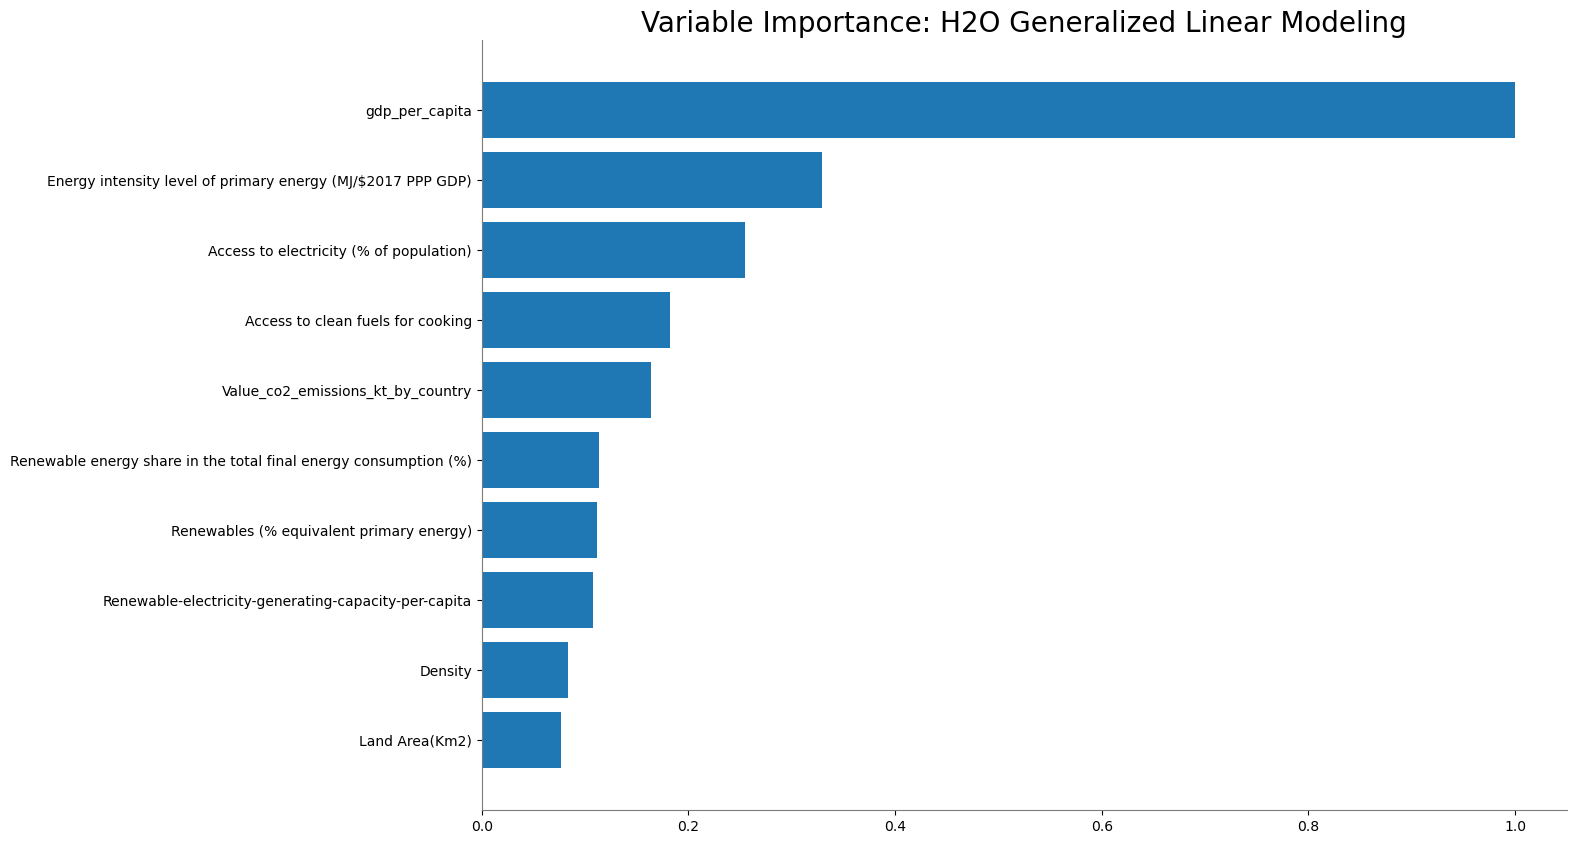

<Figure size 640x480 with 0 Axes>

In [ ]:
base_models = best_model.base_models

for model_id in base_models:
    # Retrieve the actual model object
    model = h2o.get_model(model_id)

    print(f"Variable importance for {model.model_id}:")
    model.varimp_plot()

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

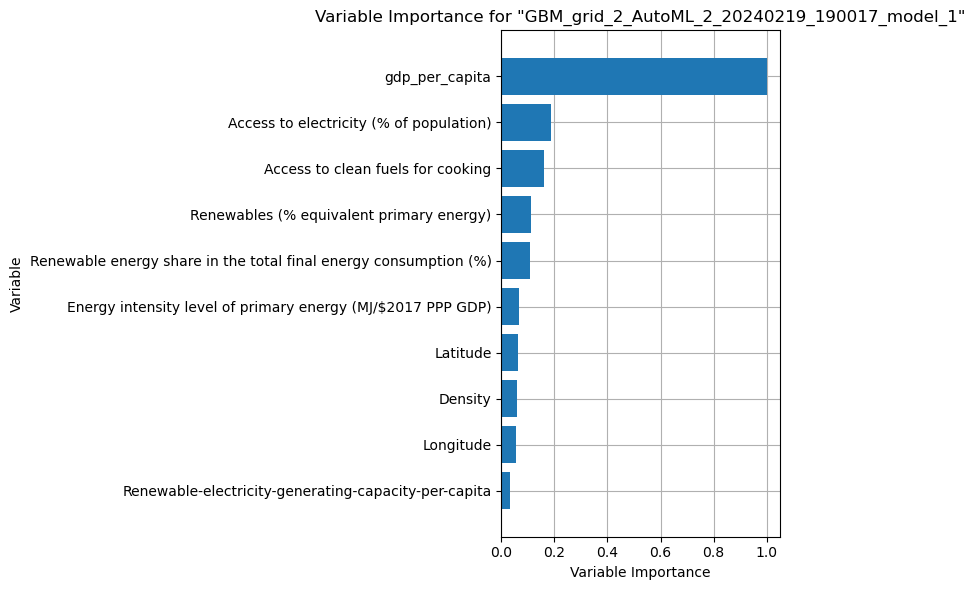

In [ ]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['varimp'])

## Is the relationship significant?

In our Model we have calculated the P Value in our OLS Summary of all numerical columns, only one predictor Financial flows to developing countries (US $) has highest `P-Value: 0.263` which suggests that it may not be statistically significant in predicting the target variable.

**Coefficient Interpretation:**
Positive coefficients (e.g., Access to electricity, Access to clean fuels) suggest a positive relationship with the response variable.
Negative coefficients (e.g., Renewable-electricity-generating-capacity-per-capita, Value_co2_emissions_kt_by_country) suggest a negative relationship with the response variable.

`R-squared:0.824`indicates that approximately 82.4% of the variability in the response variable is explained by the model. This suggests a reasonably strong fit.

**In summary, most of the predictors appear to have a statistically significant relationship with target variable.**

## Are any model assumptions violated?

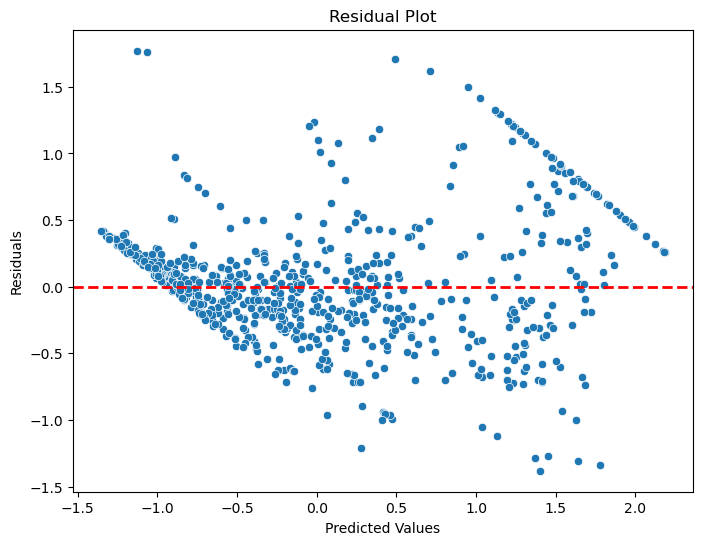

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

A well-behaved residual plot should show random scattering around zero. Patterns, trends, or non-constant variance may indicate violations of the assumptions. In our plot, most part of the scattering is not observed around zero and was randomly scattered which signifies a violation of assumptions.

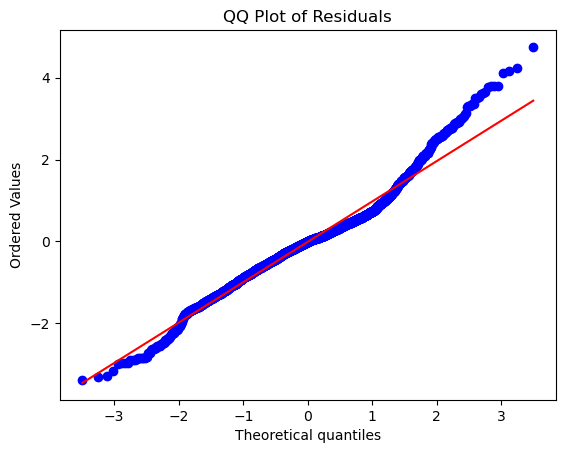

In [ ]:
import statsmodels.api as sm
from scipy.stats import probplot

# Create QQ plot
residuals_standardized = sm.OLS(y_train, X_train).fit().get_influence().resid_studentized_internal
probplot(residuals_standardized, plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

A QQ plot helps assess the normality of residuals by comparing the distribution of residuals against a theoretical normal distribution. Points should fall along a straight line if residuals are normally distributed. In our QQ Plot, the distribution seems to be falling along the regression line and is normally distributed.

 ## Is there any multicollinearity in the model?

Here are the VIF values for predictors:

- `gdp_per_capita`: VIF = 1.727024
- `Access to clean fuels for cooking`: VIF = 4.860102
- `Energy intensity level of primary energy (MJ/$2017 PPP GDP)`: VIF = 1.297835
- `Access to electricity (% of population)`: VIF = 4.649362
- `Electricity from fossil fuels (TWh)`: VIF = 4.394802
- `Electricity from renewables (TWh)`: VIF = 2.944577
- `Value_co2_emissions_kt_by_country`: VIF = 2.810134
- `Financial flows to developing countries (US $)`: VIF = 1.119069
- `Renewable energy share in the total final energy consumption (%)`: VIF = 3.917419
- `Renewables (% equivalent primary energy)`: VIF = 2.216217

Based on the provided VIF values:

- Variables with VIF values below 5 are generally considered to have low multicollinearity.
- `Access to clean fuels for cooking` and `Access to electricity (% of population)` have relatively higher VIF values, indicating potential multicollinearity.


## In the multivariate models are predictor variables independent of all the other predictor variables?

**gdp_per_capita (VIF = 1.727024):**
- This VIF value is relatively low (below 5), indicating that the variable `gdp_per_capita` has low multicollinearity with other predictor variables.

**Access to clean fuels for cooking (VIF = 4.860102):**
- This VIF value is moderate but approaching the higher end. It suggests that the variable `Access to clean fuels for cooking` is moderately correlated with other predictor variables.

**Energy intensity level of primary energy (MJ/$2017 PPP GDP) (VIF = 1.297835):**
- This VIF value is relatively low, indicating low multicollinearity for the variable `Energy intensity level of primary energy`.

**Access to electricity (% of population) (VIF = 4.649362):**
- Similar to `Access to clean fuels for cooking`, this VIF value is moderate, suggesting moderate correlation with other predictor variables.

**Electricity from fossil fuels (TWh) (VIF = 4.394802):**
- This VIF value is moderate, indicating moderate multicollinearity for the variable `Electricity from fossil fuels`.

**Electricity from renewables (TWh) (VIF = 2.944577):**
- The VIF value is moderate, suggesting moderate correlation with other predictor variables for `Electricity from renewables`.

**Value_co2_emissions_kt_by_country (VIF = 2.810134):**
- This VIF value is relatively low, indicating low multicollinearity for the variable `Value_co2_emissions_kt_by_country`.

**Financial flows to developing countries (US $) (VIF = 1.119069):**
- This VIF value is low, indicating low multicollinearity for the variable `Financial flows to developing countries`.

**Renewable energy share in the total final energy consumption (%) (VIF = 3.917419):**
- The VIF value is moderate, suggesting moderate correlation with other predictor variables for `Renewable energy share`.

**Renewables (% equivalent primary energy) (VIF = 2.216217):**
- This VIF value is relatively low, indicating low multicollinearity for the variable `Renewables (% equivalent primary energy)`.

In summary, while some variables show moderate multicollinearity, none of them have VIF values that raise serious concerns (e.g., VIF > 10).

## In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import pandas as pd


target_column = 'Primary energy consumption per capita (kWh/person)'
predictors = ['gdp_per_capita', 'Access to clean fuels for cooking',
              'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
              'Access to electricity (% of population)',
              'Electricity from fossil fuels (TWh)',
              'Electricity from renewables (TWh)',
              'Value_co2_emissions_kt_by_country',
              'Financial flows to developing countries (US $)',
              'Renewable energy share in the total final energy consumption (%)',
              'Renewables (% equivalent primary energy)']

X = data_capped_label[predictors]
y = data_capped_label[target_column]

model = LinearRegression()

rfe = RFE(model, n_features_to_select=1)  # You can adjust n_features_to_select as needed

rfe.fit(X, y)
ranking_df = pd.DataFrame({'Predictor': predictors, 'Ranking': rfe.ranking_})
print(ranking_df.sort_values(by='Ranking'))


                                           Predictor  Ranking
0                                     gdp_per_capita        1
1                  Access to clean fuels for cooking        2
2  Energy intensity level of primary energy (MJ/$...        3
8  Renewable energy share in the total final ener...        4
3            Access to electricity (% of population)        5
6                  Value_co2_emissions_kt_by_country        6
9           Renewables (% equivalent primary energy)        7
4                Electricity from fossil fuels (TWh)        8
5                  Electricity from renewables (TWh)        9
7     Financial flows to developing countries (US $)       10


The ranking represents the importance of each predictor variable in predicting the target variable, "Primary energy consumption per capita (kWh/person)." Lower rankings indicate higher importance. For instance, 'gdp_per_capita' is ranked 1, suggesting it is considered the most significant predictor, while 'Financial flows to developing countries (US $)' is ranked 10, indicating relatively lower importance.

In multivariate models, you may consider excluding predictor variables with higher rankings (less significant) to improve the model's simplicity while retaining predictive power.

##  Does the model make sense?

### Model Evaluation Summary

#### R-squared and Adjusted R-squared:
- R-squared: 0.824
- Adj. R-squared: 0.823

The R-squared values indicate that the model explains approximately 82.4% of the variance in the target variable. The adjusted R-squared accounts for the number of predictors, providing a realistic measure of goodness of fit.

#### Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE):
- RMSE: 0.148
- MAE: 0.061

Both RMSE and MAE values are relatively low, suggesting that the model's predictions closely align with the actual values. Lower values indicate better predictive accuracy.

#### Variance Inflation Factor (VIF):
- VIF values generally reasonable (most below 5).
- Higher VIF values for 'Access to clean fuels for cooking' and 'Access to electricity (% of population)' suggest potential multicollinearity.

#### Additional Metrics:
- Another R-squared value: 0.978
- Explained Variance: 0.978

These metrics reinforce the model's effectiveness, capturing approximately 97.8% of the variability in the target variable.

### Overall Assessment:
- The model demonstrates a good fit, explaining a substantial portion of the variance.
- RMSE and MAE indicate accurate predictions.
- VIF values suggest potential multicollinearity.

## Does regularization help?

#### Before Ridge Regularization:
- Root Mean Squared Error (RMSE): 0.148

#### After Ridge Regularization:
- Mean Squared Error (MSE): 0.463


The RMSE before Ridge regularization was 0.148, indicating the model's predictive accuracy on the original dataset. After applying Ridge regularization, the Mean Squared Error (MSE) increased to 0.463. The increase in MSE after Ridge regularization suggests that regularization had a substantial impact on the model. While regularization techniques like Ridge are intended to prevent overfitting by adding a penalty term to the coefficients, in this case, it appears to have led to a trade-off between bias and variance. Regularization might have reduced overfitting but at the cost of increasing errors on the data.


## Which independent variables are significant?

1. **gdp_per_capita:** p-value < 0.05 (Statistically Significant)
2. **Access to clean fuels for cooking:** p-value < 0.05 (Statistically Significant)
3. **Energy intensity level of primary energy :** p-value < 0.05 (Statistically Significant)
4. **Renewable energy share in the total final energy consumption (%):** p-value < 0.05 (Statistically Significant)
5. **Access to electricity (% of population):** p-value < 0.05 (Statistically Significant)
6. **Value_co2_emissions_kt_by_country:** p-value < 0.05 (Statistically Significant)
7. **Renewables (% equivalent primary energy):** p-value < 0.05 (Statistically Significant)
8. **Electricity from fossil fuels (TWh):** p-value < 0.05 (Statistically Significant)
9. **Electricity from renewables (TWh):** p-value < 0.05 (Statistically Significant)
10. **Financial flows to developing countries (US $):** p-value > 0.05 (Not Statistically Significant)

These predictors are considered statistically significant based on their p-values from the OLS regression model.

## Which hyperparameters are important?

There were several key hyperparameters significantly influence model performance:

- **`n_estimators`**: Specifically mentioned in ensemble methods (e.g., RandomForest or Gradient Boosting), determining the number of trees to balance accuracy and computational cost. In here, we have used the default value 100 for RandomForest Regression.

- **`alpha`**: Used for regularization (e.g., Ridge regression) to mitigate overfitting by penalizing large coefficients. In here, we have used the default value 1 for Ridge Regression.

- **`max_models`**: Sets the maximum number of models trained by AutoML, limiting the exploration to 10 models.

- **`seed`**: Establishes a random seed (1234) for reproducibility, ensuring consistent results across runs.

- **`sort_metric`**: Determines the ranking metric for model selection, with "MAE" prioritized to minimize Mean Absolute Error.

- **`project_name`**: Assigns a name ("random_split") to the AutoML project, aiding in tracking and organization.

- **`x`**: Specifies predictor variables for training, derived by excluding the target variable.

- **`y`**: Identifies the target variable ("Primary energy consumption per capita (kWh/person)") for model training.

These hyperparameters play a pivotal role in tuning models, striking a balance between complexity and generalization tailored to your dataset and analysis objectives.


#### References:

1. Aiskunks. (n.d.). Smoke Detection data AutoML - A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb. [GitHub]. https://github.com/aiskunks/YouTube/blob/4c026561cefac9c88599342389f8baf48d2b5ed5/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb

2. Stack Exchange. (n.d.). How to scale prediction back after preprocessing. https://datascience.stackexchange.com/questions/31969/how-to-scale-prediction-back-after-preprocessing

3. OpenAI. (2023). ChatGPT (Version 3.5) [Software]. Available from https://openai.com/chatgpt


MIT License

Copyright (c) 2024 Ram

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.